# Install utility package

In a terminal navigate to the parent directory where `setup.py` is located and run:
    
`pip install -e .`

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from fastai.vision import *
from azureml.core import Workspace, Datastore, Dataset, Experiment
from shutil import copyfile
import utils.experiment_helpers as utils

import warnings
warnings.filterwarnings('ignore')

# **1.0 Create your own image classifier - Dataset Creation**

In [4]:
# UPDATE ME
dataset_name = 'OnePiece'
dataset_version = 1
target_path = 'data/one_piece_crew'

In [5]:
workspace = Workspace.from_config()

In [6]:
%%capture
dataset = Dataset.get_by_name(workspace, name=dataset_name, version=dataset_version)
dataset.download(target_path=target_path, overwrite=True)

# **Step 1: Databunch for Machine Learning Model**

In this section you will create a `DataBunch`, an object that is used for model training in the fast.ai library. The databunch is unique in that as the images are loaded, all the required pre-processing is completed as well. This includes:

*   resizing
*   pixel normalisation
*   flipping, rotation, zoom
*   contrast changes
*   symmetric warping

Some of the default image transformations may not make sense depending on the application. For example, we would not flip an image of a cat vertically but for satellite imagery this would make sense.

Once you create your databunch, you can inspect a batch of the data for a sanity check.

In [7]:
path = Path(target_path) 

In [8]:
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['sanji', 'zoro'], 2, 256, 64)

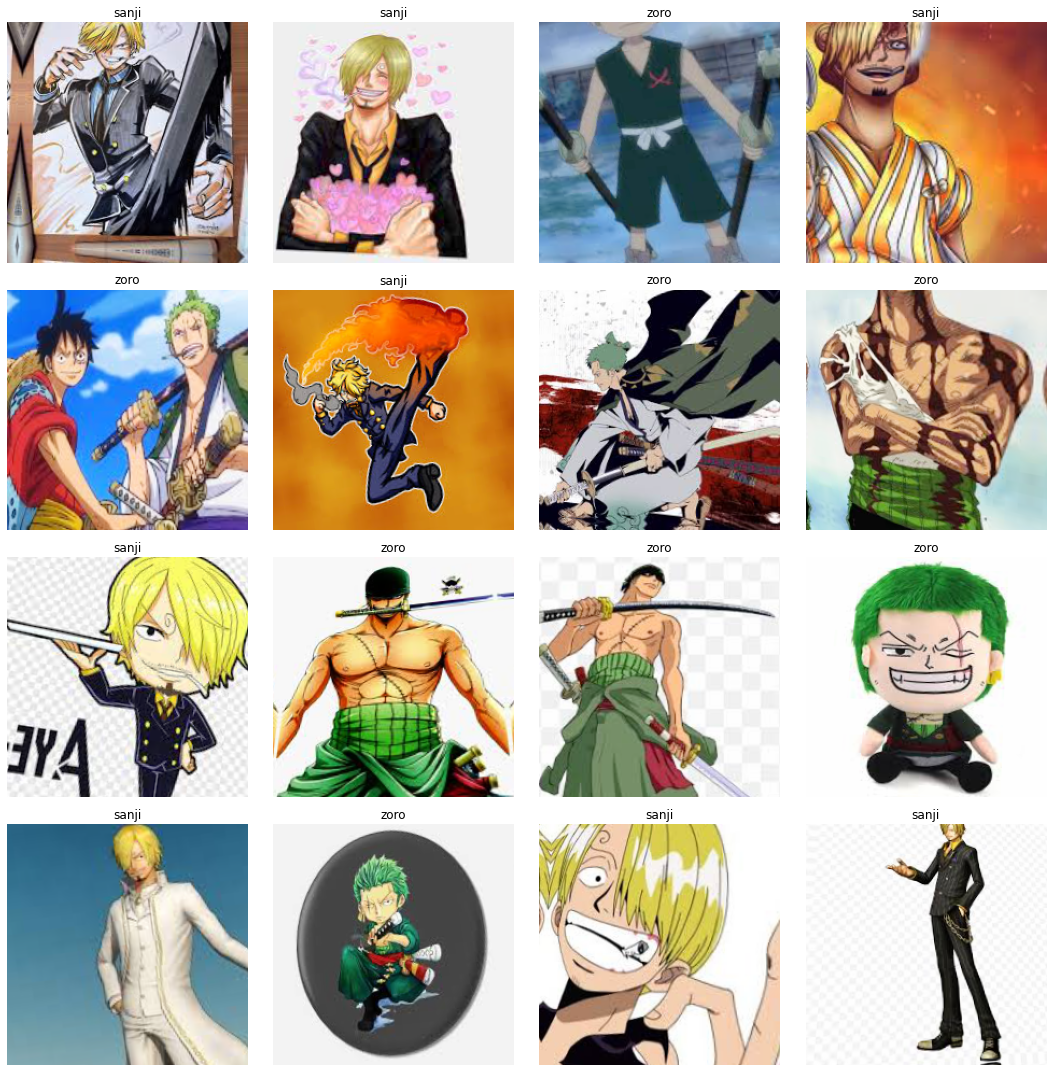

In [10]:
data.show_batch(rows=4, figsize=(15,15))

# **Step 2: Create Azure Machine Learning Experiment**

In [11]:
# UPDATE ME
experiment_name = 'imagenet_tl_ex1'

In [12]:
experiment = Experiment(workspace=workspace, name=experiment_name)

In [13]:
utils.set_random_seeds(42)

In [14]:
run = experiment.start_logging(snapshot_directory=None)

In [15]:
run.number

WARNING - Run Number's semantics may be modified in the future


3

# **Step 3: Setup Azure Experiment Logging**

In [16]:
properties = {
    'dataset_name': dataset_name,
    'dataset_version': dataset_version,
    'random_seed': 42,
    'model': 'ResNet34'
}

In [17]:
run.add_properties(properties)

WARNING - Converting non-string tag to string: (dataset_version: 1)
WARNING - Converting non-string tag to string: (random_seed: 42)


# **Step 4: Train Model**

With the data loaded and ready, you can now create your deep learning model. For this example, you will use a pre-trained machine learning model, a type of convolutional neural network called ResNet34. Don't worry if you don't know what this means. For now, all you need to know is that this model is a type of neural network that will take the images as input and output a probability for each label that you have created. You will train this model for 4 epochs. An epoch is one iteration of the complete dataset.

In [18]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(4, callbacks=[utils.LogMetricsToAzure(run, learn), utils.CustomSaveModelCallback(learn)])

epoch,train_loss,valid_loss,error_rate,time


> /mnt/batch/tasks/shared/LS_root/mounts/clusters/paula-nc6-ml-mc/code/Users/paula.tattam/ml-masterclass/notebooks/utils/experiment_helpers.py(16)on_epoch_end()
     14     def on_epoch_end(self, last_loss, last_metrics, **kwargs):
     15         import pdb; pdb.set_trace()
---> 16         self.run.log("train_loss", float(last_loss))
     17         self.run.log("val_loss", float(last_metrics[0]))
     18         self.run.log("acc", float(last_metrics[1]))



ipdb>  last_loss


tensor(0.3766)


ipdb>  last_metrics


[0.3766042, tensor(0.1094)]


ipdb>  self.learner.recorder.logs


*** AttributeError: 'Learner' object has no attribute 'logs'


ipdb>  self.learner.recorder.loss_fn


*** AttributeError: 'Learner' object has no attribute 'loss_fn'


ipdb>  self.metrics


*** AttributeError: 'LogMetricsToAzure' object has no attribute 'metrics'


ipdb>  self.learner.loss_func.metrics


*** AttributeError: 'FlattenedLoss' object has no attribute 'metrics'


ipdb>  self.learner.loss_func.metric_names


*** AttributeError: 'FlattenedLoss' object has no attribute 'metric_names'


ipdb>  self.learner.recorder.loss_func


FlattenedLoss of CrossEntropyLoss()


ipdb>  self.learner.recorder.loss_func.metric_names


*** AttributeError: 'FlattenedLoss' object has no attribute 'metric_names'


In [ ]:
learn.save('stage-1')

# **Step 5: Fine tuning and learning rates**

Once your model is working as expected, you can now train some more as well as find the best learning rate to use. The learning is a hyper parameter that you vary to help the model learn. 

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [205]:
fig = learn.recorder.plot(return_fig=True)
fig.save_fig('lr_finder.png')

AttributeError: 'Learner' object has no attribute 'recorder'

In [80]:
run.log_image(name='LR Finder', path='lr_finder.png')

SyntaxError: invalid syntax (<ipython-input-80-634debd0ffe5>, line 1)

In [58]:
# Update the max_lr values based on your plot above
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.290668,0.505582,0.125000,00:08
1,0.244502,0.501341,0.125000,00:08


In [59]:
learn.save('stage-2')

# **Step 6: Register model and upload to experiment**

In [61]:
learn = learn.load('bestmodel')

In [66]:
learn.path

PosixPath('data/one_piece_crew')

In [74]:
model_filename = f"{experiment_name}.pth"
model_path = learn.path/Path(learn.model_dir)/Path('bestmodel.pth')

In [75]:
run.upload_file(model_filename, str(model_path))

In [76]:
run.complete()

# **Step 7: Inspecting the Results**

Next you will inspect the results of your model. Here you will get to see:

*   Which categories the model confused the most
*   Whether the misclassifications were reasonable or not

And lastly, you can view the confusion matrix to understand the distribution of errors the model makes.

**Before running the below cells, navigate to the jupyter notebook server. The below widgets don't work with jupyter lab.**

In [82]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

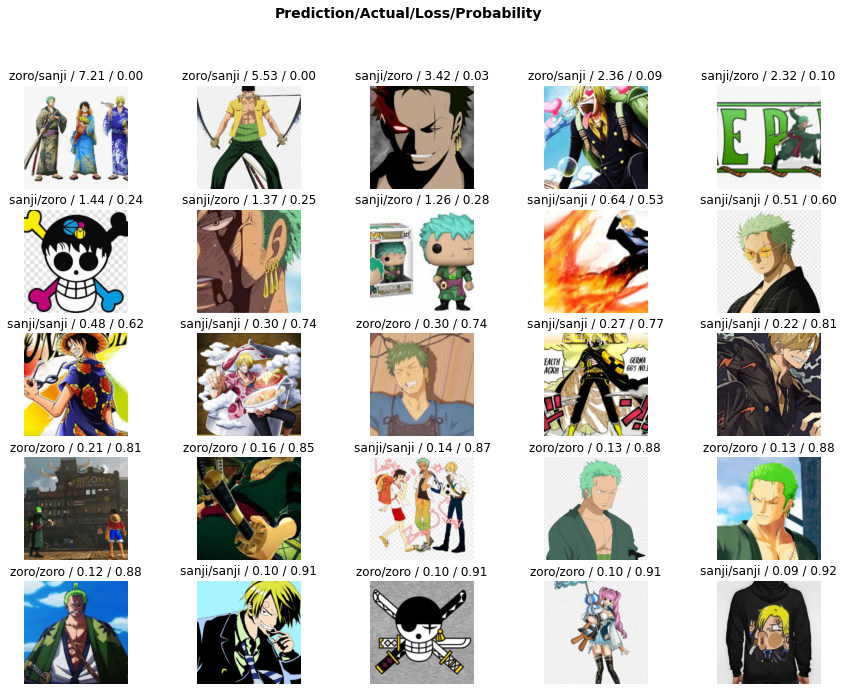

In [83]:
interp.plot_top_losses(25, figsize=(15,11))

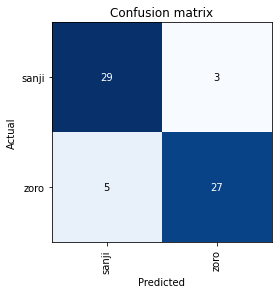

In [84]:
interp.plot_confusion_matrix()

In [85]:
interp.most_confused(min_val=2)

[('zoro', 'sanji', 5), ('sanji', 'zoro', 3)]

# **Step 8: Data clean up**

Some of the top losses are not due to our model performing badly. Instead, they are due to incorrect images in our training data. fast.ai has a `ImageCleaner` widget that makes cleaning this kind of thing up super easy.

Unfortunately, this widget does not work with jupyter lab or google collab. To run the following lines of code you need to run this notebook locally. You can download a copy of this notebook from google collab or clone the github repo. Make sure you complete the 'nice to have' prerequisites defined in the github readme.

Once you have the notebook downloaded locally:

* run the 'from fastai.vision import *' cell
* Repeat Steps 3 & 4 above
* Download the saved model export and save in the 'models' directory

Once the above steps are complete, you can run the below cells. You will:

* view images with the highest losses and delete or re-label
* find images that are potential duplicates in the dataset

In [88]:
from fastai.widgets import *

In [89]:
db = (ImageList.from_folder(path)
      .split_none()
      .label_from_folder()
      .transform(get_transforms(), size=224)
      .databunch())

In [91]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('bestmodel')

Learner(data=ImageDataBunch;

Train: LabelList (320 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
sanji,sanji,sanji,sanji,sanji
Path: data/one_piece_crew;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/one_piece_crew;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

In [92]:
ds, idx = DatasetFormatter().from_toplosses(learn_cln)

In [93]:
ds, idx = DatasetFormatter().from_toplosses(learn_cln)

In [94]:
ImageCleaner(ds, idx, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

When you are satisfied with your cleaning or reach the end of the available data, you can now move onto finding potential duplicates. A `cleaned.csv` file will have been created for you from the above step and you will need to use this file for the next step.

Using pandas, we can preview the contents of the newly created file to see what has been created.

In [96]:
import pandas as pd

In [97]:
df = pd.read_csv(f'{target_path}/cleaned.csv')

In [98]:
df.head()

,name,label
0,sanji/00000000.jpg,sanji
1,sanji/00000001.jpg,sanji
2,sanji/00000002.jpg,sanji
3,sanji/00000003.jpg,sanji
4,sanji/00000004.jpg,sanji


Now we can load the new csv file and use this to find duplicate images.

In [99]:
db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
       .split_none()
       .label_from_df()
       .transform(get_transforms(), size=224)
       .databunch()
)

This next cell might take some time to run as we need to run the images through the model and use the outputs from the last layer to calculate the similarities.

In [100]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-1');

In [101]:
ds, idxs = DatasetFormatter().from_similars(learn_cln, pool=None)

Getting activations...


Computing similarities...


In [102]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

# **Step 9: Train a new model on cleaned data**

## Upload new version for updated dataset

In [203]:
# UPDATE ME
updated_data_dir = 'updated_one_piece_crew'

Copy images to keep to a new directory and upload to the default azure datastore

In [196]:
for image in path.rglob('**/*.jpg'):
    name = '/'.join(str(image).split('/')[-2:])
    if df.name.str.contains(name).any():
        new_path = str(image).replace('data/one_piece_crew', updated_data_dir)
        if not os.path.exists(Path(new_path).parent):
            os.makedirs(Path(new_path).parent)
        copyfile(image, new_path)

In [198]:
%%capture
datastore_name = 'workspaceblobstore'
datastore = Datastore.get(workspace, datastore_name)
datastore.upload(updated_data_dir, target_path=updated_data_dir)
datastore_paths = [(datastore, updated_data_dir)]
image_dataset = Dataset.File.from_files(path=datastore_paths)

In [183]:
description = "Incorrect labels and duplicates removed."

In [201]:
image_dataset.register(
    workspace=workspace,
    name=dataset_name,
    description=description,
    create_new_version=True
)

{
  "source": [
    "('workspaceblobstore', 'updated_one_piece_crew')"
  ],
  "definition": [
    "GetDatastoreFiles"
  ],
  "registration": {
    "id": "5699cc59-b300-4ec0-a739-a656064163e2",
    "name": "OnePiece",
    "version": 2,
    "description": "Incorrect labels and duplicates removed.",
    "workspace": "Workspace.create(name='ml-masterclass-ws', subscription_id='e36c4f51-a63e-4dd2-845f-26e8fea75d45', resource_group='ml-masterclass-rg')"
  }
}

## Go back to the start of this notebook and re-run with updated dataset.